<a href="https://colab.research.google.com/github/josephxlp/AAATrashCode/blob/PointCloudSemanticSegmentationwithSAM2023/samb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import time
import os

import torch
import cv2
import matplotlib.pyplot as plt

In [ ]:
rootdir = "/content/drive/MyDrive/PYTHON3DDATA/P4_3DPointCloudSemanticSegmentationwithSAM2023/sam3d"
CHECKPOINT_PATH =  "/content/drive/MyDrive/PYTHON3DDATA/P4_3DPointCloudSemanticSegmentationwithSAM2023/sam3d/models/sam_vit_h_4b8939-002.pth"
MODEL_TYPE = "vit_h"
IMAGE_PATH = "/content/drive/MyDrive/PYTHON3DDATA/P4_3DPointCloudSemanticSegmentationwithSAM2023/sam3d/data/NAAVIS_EXTERIOR.jpg"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
#sam.to(device=DEVICE)
print('Model Loaded to Device')

Model Loaded to Device


In [ ]:
DATA_PATH = "/content/drive/MyDrive/PYTHON3DDATA/P4_3DPointCloudSemanticSegmentationwithSAM2023/sam3d/data/toulouse_poux.xyz"
pcd =np.loadtxt(DATA_PATH, delimiter=';')
coords = pcd[:,:3]
colors = pcd[:,3:6]

In [ ]:
#%% 3. Parameters settings

resolution_y = 400
center_coordinates = [-2, 30, 8.7]

In [ ]:
#%% 4. Translate the point cloud by the negation of the center coordinates
translated_points = coords - center_coordinates

In [ ]:
#%% 5. Convert 3D point cloud to spherical coordinates
theta = np.arctan2(translated_points[:, 1], translated_points[:, 0])
phi = np.arccos(translated_points[:, 2] / np.linalg.norm(translated_points, axis=1))

In [ ]:
#%% 6. Map spherical coordinates to pixel coordinates
x = (theta + np.pi) / (2 * np.pi) * (2 * resolution_y)
y = phi / np.pi * resolution_y

In [ ]:
#%% 7. Create the spherical image with RGB channels
resolution_x = 2 * resolution_y
spherical_image = np.zeros((resolution_y, resolution_x, 3), dtype=np.uint8)


In [ ]:
#%% 8. Create the mapping between point cloud and image coordinates
mapping = np.full((resolution_y, resolution_x), -1, dtype=int)
mapping_multiple = np.full((resolution_y, resolution_x), -1, dtype=object)

In [ ]:
#%% 9. Assign Points to the Image pixels

for i in range(len(translated_points)):
    ix = np.clip(int(x[i]), 0, resolution_x - 1)
    iy = np.clip(int(y[i]), 0, resolution_y - 1)
    if mapping[iy, ix] == -1 or np.linalg.norm(translated_points[i]) < np.linalg.norm(translated_points[mapping[iy, ix]]):
        mapping[iy, ix] = i
        spherical_image[iy, ix] = colors[i]#np.array(colors[i], dtype=np.uint8)
    if mapping_multiple[iy, ix] == -1:
        mapping_multiple[iy, ix] = []
    else:
        mapping_multiple[iy,ix].append(i)


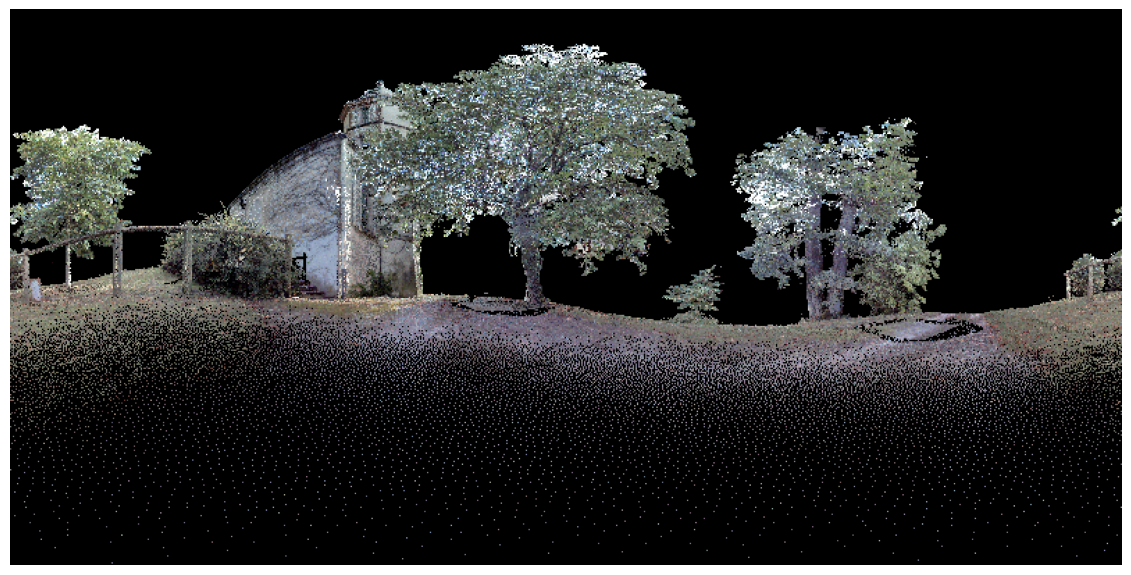

In [ ]:

#%% 10. Plotting and Exporting the RGB Panorama
fig = plt.figure(figsize=(np.shape(spherical_image)[1]/72, np.shape(spherical_image)[0]/72))
fig.add_axes([0,0,1,1])

plt.imshow(spherical_image)
plt.axis('off')
plt.savefig(DATA_PATH.split(".xyz")[0]+".jpg")

In [ ]:
#np.savetxt(DATA_PATH.split(".xyz")[0]+"_result.xyz", modified_point_cloud, delimiter=';', fmt='%1.9f')
# man modified

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
IMAGE_PATH = "/content/drive/MyDrive/PYTHON3DDATA/P4_3DPointCloudSemanticSegmentationwithSAM2023/sam3d/data/NAAVIS_EXTERIOR.jpg"

In [ ]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [ ]:
t0 = time.time()
result = mask_generator.generate(image_rgb)
t1 = time.time()
print(f"mask generation time: {t1-t0:.0f} seconds")

mask generation time: 10 seconds


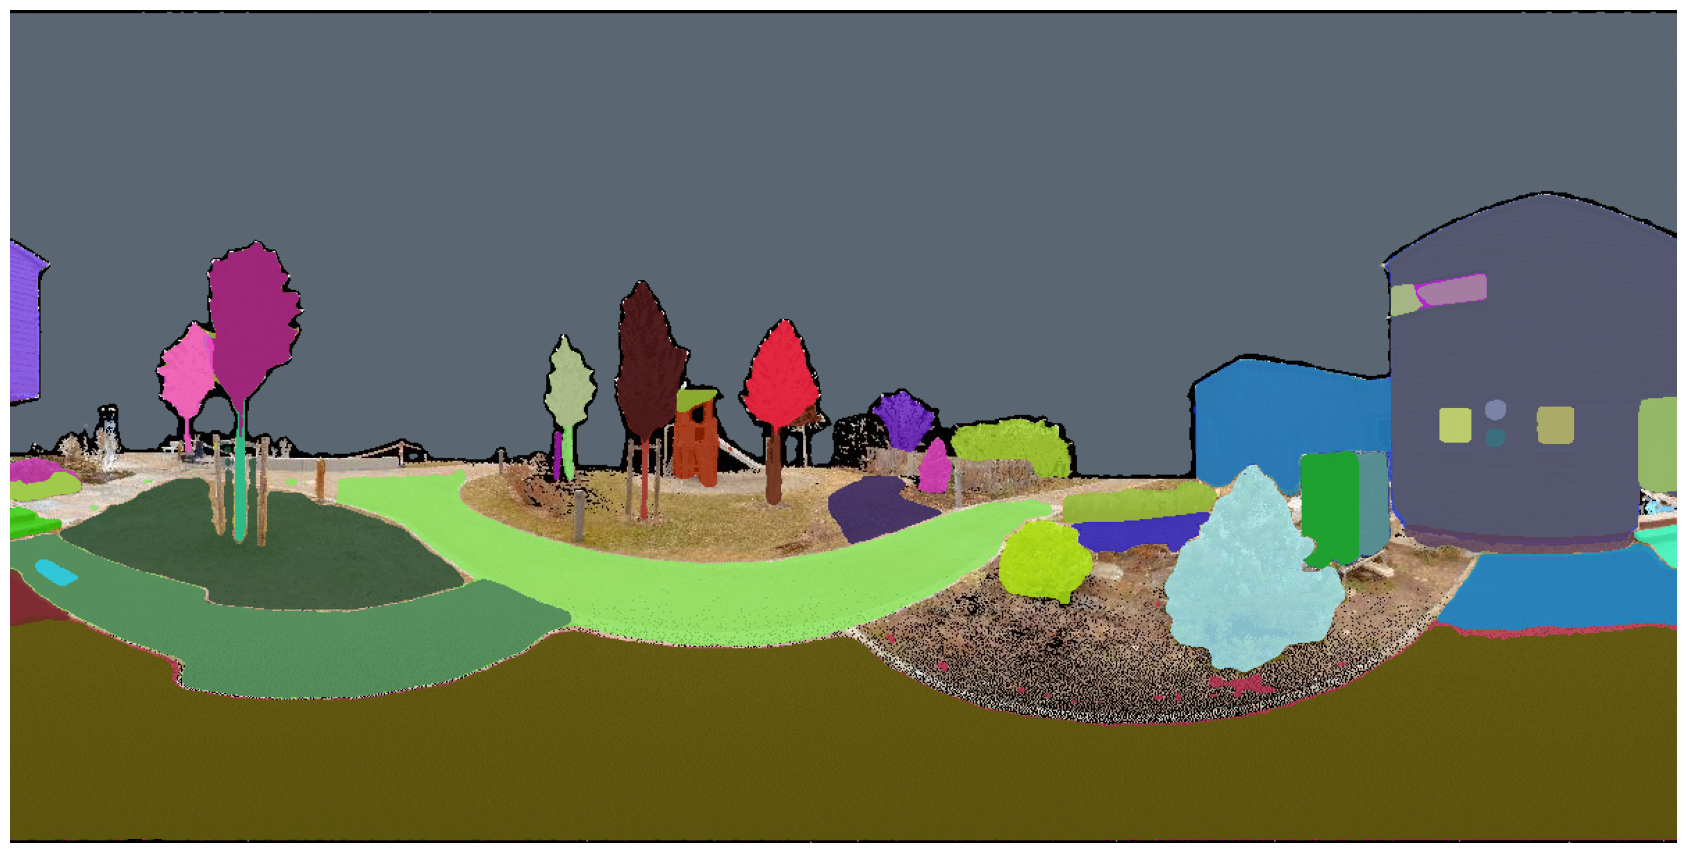

In [ ]:
def sam_masks(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    # polygons = []
    # color = []
    c_mask=[]
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.8)))
        c_mask.append(img)
    return c_mask

fig = plt.figure(figsize=(np.shape(image_rgb)[1]/72, np.shape(image_rgb)[0]/72))
fig.add_axes([0,0,1,1])

plt.imshow(image_rgb)
color_mask = sam_masks(result)
plt.axis('off')
plt.savefig(IMAGE_PATH.split('.jpg')[0]+"_segmented.jpg")